In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
from keras import backend as K
from keras.losses import kld
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

import tensorflow as tf
from tensorflow.python.framework import ops

Using TensorFlow backend.


In [2]:
def build_model():
    """Function returning keras model instance.
    
    Model can be
     - Trained here
     - Loaded with load_model
     - Loaded from keras.applications
    """
    return VGG16(include_top=True, weights='imagenet')

In [3]:
def load_image(path, preprocess=True):
    """Function to load and preprocess image."""
    x = image.load_img(path, target_size=(224, 224))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x


def deprocess_image(x):
    """
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)


def build_guided_model():
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = model.input
    layer_output = model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val


def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    cam = cv2.resize(cam, (224, 224), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

In [4]:
def grad_cam_batch(input_model, imgs, category_indices, activation_layer):
    """GradCAM method for visualizing input saliency. 
    Does the same as grad_cam but processes multiple images in one run."""
    loss = tf.gather_nd(input_model.output, np.dstack([range(imgs.shape[0]), category_indices])[0])
    layer_output = input_model.get_layer(activation_layer).output
    grads = K.gradients(loss, layer_output)[0]
    gradient_fn = K.function([input_model.input, K.learning_phase()], [layer_output, grads])

    conv_output, grads_val = gradient_fn([imgs, 0])    

    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.einsum('ijkl,il->ijk', conv_output, weights)
    
    new_cams = np.empty((imgs.shape[0], 224, 224))
    for i in range(new_cams.shape[0]):
        tmp = cams[i] - cams[i].mean()
        tmp = (tmp + 1e-10) / (np.linalg.norm(tmp, 2) + 1e-10)
        new_cams[i] = cv2.resize(tmp, (224, 224), cv2.INTER_LINEAR)
        new_cams[i] = np.maximum(new_cams[i], 0)
        new_cams[i] = new_cams[i] / new_cams[i].max()
    
    return new_cams

In [5]:
def compute_saliency(model, guided_model, img_path, cls=-1, visualize=True):
    preprocessed_input = load_image(img_path)

    predictions = model.predict(preprocessed_input)
    top_n = 5
    top = decode_predictions(predictions, top=top_n)[0]
    classes = np.argsort(predictions[0])[-top_n:][::-1]
    print('Model prediction:')
    for c, p in zip(classes, top):
        print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
    if cls == -1:
        cls = np.argmax(predictions)
    class_name = decode_predictions(np.eye(1, 1000, cls))[0][0][1]
    print("Explanation for '{}'".format(class_name))
    
    gradcam = grad_cam(model, preprocessed_input, cls, 'block5_conv3')
    gb = guided_backprop(guided_model, preprocessed_input, 'block5_conv3')
    guided_gradcam = gb * gradcam[..., np.newaxis]

    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, grad_cam

In [6]:
model = build_model()
guided_model = build_guided_model()

Model prediction:
	boxer          	(242)	with probability 0.420
	bull_mastiff   	(243)	with probability 0.282
	tiger_cat      	(282)	with probability 0.053
	tiger          	(292)	with probability 0.050
	Great_Dane     	(246)	with probability 0.050
Explanation for 'boxer'


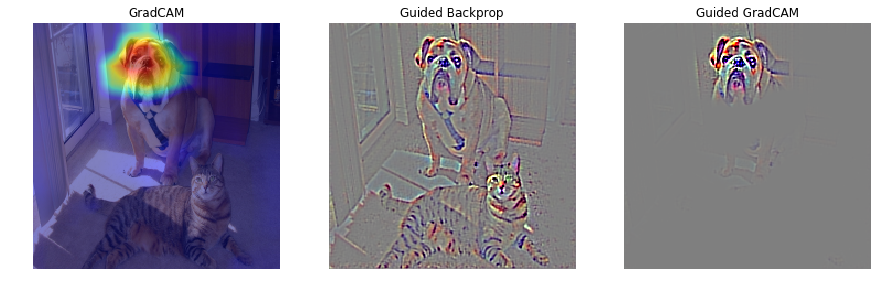

Model prediction:
	boxer          	(242)	with probability 0.420
	bull_mastiff   	(243)	with probability 0.282
	tiger_cat      	(282)	with probability 0.053
	tiger          	(292)	with probability 0.050
	Great_Dane     	(246)	with probability 0.050
Explanation for 'tiger_cat'


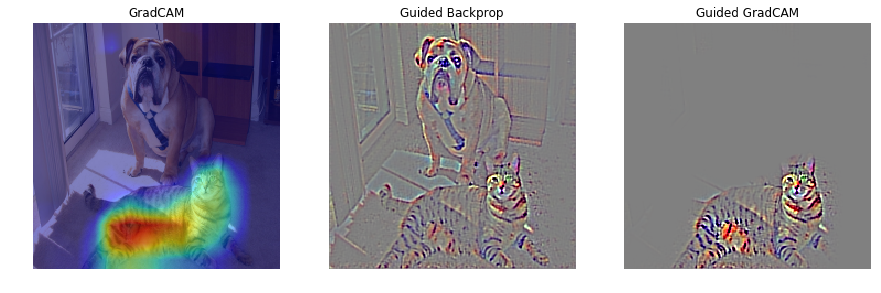

In [7]:
gradcam, gb, grad_cam = compute_saliency(model, guided_model, 'examples/cat_dog.png', cls=-1)
gradcam, gb, grad_cam = compute_saliency(model, guided_model, 'examples/cat_dog.png', cls=282)

# Generating explanations for many images

Load all images from the folder into one array X

In [8]:
dir_path = '/scratch2/Datasets/imagenet100/val/'
files = os.listdir(dir_path)
N = len(files)

X = np.empty((N, 224, 224, 3))
for i, file in enumerate(files):
    x = image.load_img(dir_path + file, target_size=(224, 224))
    X[i] = image.img_to_array(x)
X = preprocess_input(X)

### Generate and save GradCAM saliency maps

In [12]:
# Let's set classes for explanations as most probable class for each image.
top = np.argmax(model.predict(X), 1)

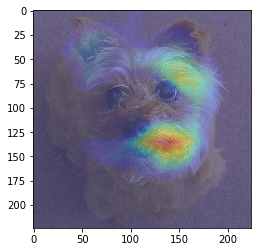

In [13]:
gradcam = np.empty((X.shape[:-1]))
batch_size = 32
for i in range((N + batch_size - 1) // batch_size):
    start = i * batch_size
    end = min((i+1) * batch_size, N)
    gradcam[start:end] = grad_cam_batch(model, X[start:end], top[start:end], 'block5_conv3')
    
gradcam.tofile('gradcam.npy')

plt.imshow(np.flip(deprocess_image(X[2]), -1))
plt.imshow(gradcam[2], alpha=0.3, cmap='jet')
plt.show()

### Generate and save Guided Backpropagation saliency maps

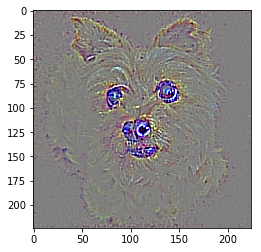

In [14]:
gbp = np.empty((X.shape))
batch_size = 32
for i in range((N + batch_size - 1) // batch_size):
    start = i * batch_size
    end = min((i+1) * batch_size, N)
    gbp[start:end] = guided_backprop(guided_model, X[start:end], 'block5_conv3')
    
gbp.tofile('guided_backprop.npy')

plt.imshow(np.flip(deprocess_image(gbp[2]), -1), cmap='jet')
plt.show()

### Generate and save Guided GradCAM

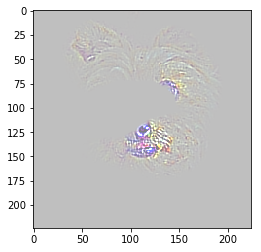

In [15]:
guided_gradcam = gbp * gradcam[..., np.newaxis]
guided_gradcam.tofile('guided_gradcam.npy')

plt.imshow(np.flip(deprocess_image(guided_gradcam[2]), -1), alpha=0.5, cmap='jet')
plt.show()